In [1]:
from dotenv import load_dotenv

load_dotenv()

True

### Nodes & Edges

In [2]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
from langgraph.graph import END, MessageGraph

model = ChatOpenAI(temperature=0)

def add_one(input: list[HumanMessage]):
    input[0].content = input[0].content + "a"
    return input


graph = MessageGraph()

graph.add_node("branch_a", add_one)
graph.add_edge("branch_a", "branch_b")
graph.add_edge("branch_a", "branch_c")

graph.add_node("branch_b", add_one)
graph.add_node("branch_c", add_one)

graph.add_edge("branch_b", "final_node")
graph.add_edge("branch_c", "final_node")

graph.add_node("final_node", add_one)
graph.add_edge("final_node", "end_code")

graph.add_node("end_code", add_one)
graph.add_edge("end_code", END)

graph.set_entry_point("branch_a")

runnable = graph.compile()


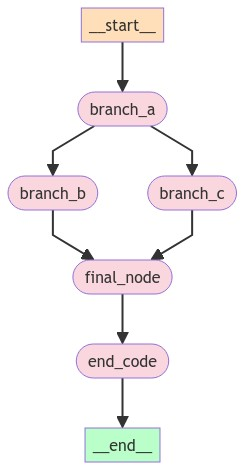

In [3]:
from IPython.display import Image, display

display(Image(runnable.get_graph().draw_mermaid_png()))

In [4]:
runnable.invoke("a")

[HumanMessage(content='aaaaaa', id='983560e4-e664-4fa5-a587-bfef3e041972')]

### Conditional Edges

In [5]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
from langgraph.graph import END, MessageGraph

model = ChatOpenAI(temperature=0)


def entry(input: list[HumanMessage]):
    return input

def work_with_b(input: list[HumanMessage]):
    print("Using branch B")
    return "b"

def work_with_c(input: list[HumanMessage]):
    print("Using branch C")
    return "c"

def router(input: list[HumanMessage]):
    if "use_b" in input[0].content:
        return "branch_b"
    else:
        return "branch_c"

graph = MessageGraph()

graph.add_node("branch_a", entry)
graph.add_node("branch_b", work_with_b)
graph.add_node("branch_c", work_with_c)

graph.add_conditional_edges(
    "branch_a",
    router,
    {"branch_b": "branch_b", "branch_c": "branch_c"}
)
graph.add_edge("branch_b", END)
graph.add_edge("branch_c", END)

graph.set_entry_point("branch_a")

runnable = graph.compile()

In [6]:
runnable = graph.compile()

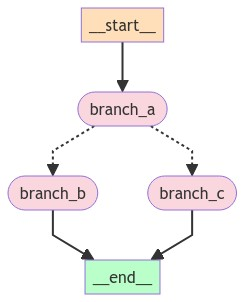

In [7]:
display(Image(runnable.get_graph().draw_mermaid_png()))

In [8]:
runnable.invoke("hello")

Using branch C


[HumanMessage(content='hello', id='22ae64fe-d2ae-444f-8215-0f8afe82bb24'),
 HumanMessage(content='c', id='21b04d02-c14b-4975-b087-605679c9965f')]

In [9]:
runnable.invoke("I want to use_b")

Using branch B


[HumanMessage(content='I want to use_b', id='ebd31c13-3526-4a4d-adfe-cc943aee08f8'),
 HumanMessage(content='b', id='6db3ebed-e035-4979-89f1-e00a71c97eaa')]

### Cycles

In [10]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
from langgraph.graph import END, MessageGraph

model = ChatOpenAI(temperature=0)

def entry(input: list[HumanMessage]):
    print("Agent processing:", input[-1].content)
    if "end" in input[-1].content:
        return ["end"]
    return ["continue"]

def action(input: list[HumanMessage]):
    print("Action taken:", [msg.content for msg in input])
    if len(input) > 5:
        input.append(HumanMessage(content="end"))
    else:
        input.append(HumanMessage(content="continue"))
    return input

def should_continue(input: list):
    last_message = input[-1]
    if "end" in last_message.content:
        return "__end__"
    return "action"


graph = MessageGraph()

graph.add_node("agent", entry)
graph.add_node("action", action)

graph.add_conditional_edges(
    "agent",
    should_continue,
    {"action": "action", "__end__": END}
)
graph.add_edge("action", "agent")

graph.set_entry_point("agent")

runnable = graph.compile()


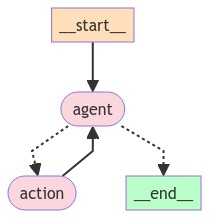

In [11]:
display(Image(runnable.get_graph().draw_mermaid_png()))

In [12]:
runnable.invoke("Hello")

Agent processing: Hello
Action taken: ['Hello', 'continue']
Agent processing: continue
Action taken: ['Hello', 'continue', 'continue', 'continue']
Agent processing: continue
Action taken: ['Hello', 'continue', 'continue', 'continue', 'continue', 'continue']
Agent processing: end


[HumanMessage(content='Hello', id='52de4469-d7ba-47d4-bf9c-adcf2a3a35cb'),
 HumanMessage(content='continue', id='957e0f53-a251-457a-9009-0bd01191be15'),
 HumanMessage(content='continue', id='816b2c10-7567-40a3-bf49-d1e2f070ebde'),
 HumanMessage(content='continue', id='e09edd5b-b5de-45a4-a0b2-98fab74a6bf0'),
 HumanMessage(content='continue', id='b950cd5c-5a0d-4142-b186-bd6b29e3f584'),
 HumanMessage(content='continue', id='cbf89838-c3e9-4980-ad1c-f0e862fe5278'),
 HumanMessage(content='end', id='a4f044b7-9b68-47e5-a973-2751ba58e037'),
 HumanMessage(content='end', id='5b119c85-f945-4841-8b59-531f149679f2')]

### AgentState

In [13]:
import random
from langgraph.graph import StateGraph, END
from typing import TypedDict, Literal

class AgentState(TypedDict):
    x: int
    y: int
    iteration: int

def increase_x_and_y(state: AgentState) -> AgentState:
    state['x'] += random.randint(0, 10)
    state['y'] += random.randint(0, 10)
    state['iteration'] += 1
    return state

def decrease_x_and_y(state: AgentState) -> AgentState:
    state['x'] -= random.randint(0, 10)
    state['y'] -= random.randint(0, 10)
    state['iteration'] += 1
    return state

def should_continue(state: AgentState) -> Literal["branch_a", "branch_b", "__end__"]:
    if state['iteration'] >= 10:
        return "__end__"
    elif state['x'] % 2 == 0:
        return "branch_a"
    else:
        return "branch_b"

workflow = StateGraph(AgentState)

workflow.add_node("branch_a", increase_x_and_y)
workflow.add_node("branch_b", decrease_x_and_y)

workflow.set_entry_point("branch_a")

workflow.add_conditional_edges(
    "branch_a",
    should_continue,
    {"branch_a": "branch_a", "branch_b": "branch_b", "__end__": END}
)
workflow.add_conditional_edges(
    "branch_b",
    should_continue,
    {"branch_a": "branch_a", "branch_b": "branch_b", "__end__": END}
)

app = workflow.compile()

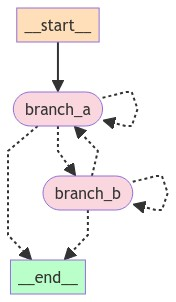

In [14]:
display(Image(app.get_graph().draw_mermaid_png()))

In [15]:
initial_state = {"x": 10, "y": 10, "iteration": 0}
result = app.invoke(initial_state)
print(result)

{'x': 25, 'y': 26, 'iteration': 10}


### Real Agent - now lets create an Agent that actually does something

In [16]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(temperature=0)

In [17]:
from typing import TypedDict, Annotated, Sequence
import operator
from langchain_core.messages import BaseMessage


class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    api_call_count: int = 0

In [18]:
from langchain_core.tools import tool
import random

@tool
def fake_weather_api(city: str) -> str:
    """Check the weather in a specified city. The API is available randomly, approximately every third call."""

    if random.randint(1, 3) == 1:  # Approximately one-third chance
        return "Sunny, 22°C"
    else:
        return "Service temporarily unavailable"

In [19]:
print(fake_weather_api("New York"))
print(fake_weather_api("London"))
print(fake_weather_api("Berlin"))

Service temporarily unavailable
Service temporarily unavailable
Sunny, 22°C


c:\Users\User\Desktop\langgraph\app\Lib\site-packages\langchain_core\_api\deprecation.py:119: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


In [20]:
llm_with_tools = model.bind_tools([fake_weather_api])

In [21]:
from langchain_core.messages import HumanMessage, ToolMessage

tool_mapping = {"fake_weather_api": fake_weather_api}

messages = [HumanMessage("How will the weather be in munich today? I would like to eat outside if possible")]
llm_output = llm_with_tools.invoke(messages)
messages.append(llm_output)
print(messages)

[HumanMessage(content='How will the weather be in munich today? I would like to eat outside if possible'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Scm1JL8WDYqRfM7HItP4zNnC', 'function': {'arguments': '{"city":"Munich"}', 'name': 'fake_weather_api'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 86, 'total_tokens': 103}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-87682045-03df-451b-be58-67fecb550037-0', tool_calls=[{'name': 'fake_weather_api', 'args': {'city': 'Munich'}, 'id': 'call_Scm1JL8WDYqRfM7HItP4zNnC'}])]


In [22]:
for tool_call in llm_output.tool_calls:
    tool = tool_mapping[tool_call["name"].lower()]
    tool_output = tool.invoke(tool_call["args"])
    messages.append(ToolMessage(content=tool_output, tool_call_id=tool_call["id"]))

llm_with_tools.invoke(messages)

AIMessage(content='The weather in Munich today is sunny with a temperature of 22°C. It seems like a perfect day to eat outside! Enjoy your meal!', response_metadata={'token_usage': {'completion_tokens': 30, 'prompt_tokens': 118, 'total_tokens': 148}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-47218b80-b77e-4668-bf57-fd6760ada559-0')

In [23]:
def should_continue(state: AgentState):
    print("STATE:", state)
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls:
        return "end"
    else:
        return "continue"

def call_model(state: AgentState):
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response], "api_call_count": state["api_call_count"]}

def call_tool(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    tool_call = last_message.tool_calls[0]
    tool = tool_mapping[tool_call["name"].lower()]
    tool_output = tool.invoke(tool_call["args"])
    state['api_call_count'] += 1
    print("Tool output:", tool_output)
    print("API call count after this tool call:", state['api_call_count'])
    tool_message = ToolMessage(content=tool_output, tool_call_id=tool_call["id"])
    return {"messages": [tool_message], "api_call_count": state["api_call_count"]}


In [24]:
from langgraph.graph import StateGraph, END

workflow = StateGraph(AgentState)

workflow.add_node("agent", call_model)
workflow.add_node("action", call_tool)

workflow.set_entry_point("agent")

workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue": "action",
        "end": END,
    },
)
workflow.add_edge("action", "agent")
workflow.set_entry_point("agent")

app = workflow.compile()

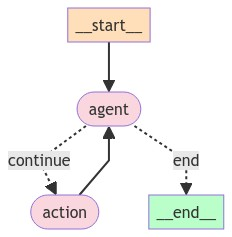

In [25]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except:
    pass

In [26]:
from langchain_core.messages import SystemMessage

system_message =  SystemMessage(content="You are responsible for answering user questions. You use tools for that, These tools sometimes fail and you are very resilient and trying them again")
human_message = HumanMessage(content="How is the weather in munich today?")
messages = [system_message, human_message]

result = app.invoke({"messages": messages, "api_call_count": 0})

STATE: {'messages': [SystemMessage(content='You are responsible for answering user questions. You use tools for that, These tools sometimes fail and you are very resilient and trying them again'), HumanMessage(content='How is the weather in munich today?'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_S3jZpreO0nHdZdNnJjcd5AxY', 'function': {'arguments': '{"city":"Munich"}', 'name': 'fake_weather_api'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 105, 'total_tokens': 122}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-8190f5f1-fbfd-4f5d-a4b7-8193fea8aa18-0', tool_calls=[{'name': 'fake_weather_api', 'args': {'city': 'Munich'}, 'id': 'call_S3jZpreO0nHdZdNnJjcd5AxY'}])], 'api_call_count': 0}
Tool output: Sunny, 22°C
API call count after this tool call: 1
STATE: {'messages': [SystemMessage(content='You are responsible for answering user quest

In [27]:
print(result["messages"][-1].content)
print(result["api_call_count"])

The weather in Munich today is sunny with a temperature of 22°C.
1
